In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.evaluation import run_noise_experiment, calc_av_p_scores, construct_single_box_df, _compute_prec_rec_f1, _select_significant_entries, get_tp_fn_fn, adjust_box_widths
from pals.feature_extraction import DataSource

from pals.PALS import PALS
from pals.ORA import ORA
from pals.GSEA import GSEA
from pals.common import *

2020-02-27 15:20:50.829 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2020-02-27 15:20:50.830 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2020-02-27 15:20:51.903 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

### Define some useful methods

In [6]:
def get_data_source(sample_fnames, pathway_names, percent, prob_missing_peaks, noise_mean, noise_std):    
    bg_pw = 100
    min_replace = 5000
    
    int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=bg_pw)
    int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
    ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)
    
    # plot the intensity matrix
    measurement_df = np.log(ds.get_measurements())
    print(measurement_df.shape)
    # plot_intensity_matrix(measurement_df)
    
    return ds

In [7]:
def run_experiment(ds, pathway_names, pals_plage_weights, pals_hg_weights):  
    true_answers = set(pathway_names.keys())
    significant_column = 'case/control comb_p'
    pals_num_resamples = 1000
    pals_resample = True if pals_num_resamples > 0 else False
    threshold = SIGNIFICANT_THRESHOLD    
    
    results = []
    f1_mat = np.zeros((len(pals_plage_weights), len(pals_hg_weights)))
    for i in range(len(pals_plage_weights)):
        pals_plage_weight = pals_plage_weights[i]

        for j in range(len(pals_hg_weights)):
            pals_hg_weight = pals_hg_weights[j]
            # logger.info('Running PALS with plage_weight=%d hg_weight=%d' % (pals_plage_weight, pals_hg_weight))

            # run PALS and select the top-N significant pathways from the results
            pals = PALS(ds, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
            df = pals.get_pathway_df(resample=pals_resample)
            filtered_df = _select_significant_entries(df, significant_column, threshold, None)
            TP, FP, FN, prec, rec, f1, TP_items, FP_items, FN_items = _compute_prec_rec_f1(true_answers, set(filtered_df.index.values))
            row = [pals_plage_weight, pals_hg_weight, TP, FP, FN, prec, rec, f1]
            results.append(row)

            f1_mat[i, j] = f1

    results_df = pd.DataFrame(results, columns=['plage_weight', 'hg_weight', 'TP', 'FP', 'FN', 'prec', 'rec', 'F1'])
    return results_df, f1_mat

In [8]:
def plot_heatmap(f1_mat, out_file=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    img = ax.matshow(f1_mat)
    ax.set_xticks(pals_hg_weights-1)
    ax.set_xticklabels(pals_hg_weights)
    ax.set_xlabel('Hypergeometric weights')
    ax.set_yticks(pals_plage_weights-1)
    ax.set_yticklabels(pals_plage_weights)
    ax.set_ylabel('PLAGE weights')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    fig.colorbar(img)
    plt.title('$F_{1}$ scores under varying parameters', y=1.08)
    plt.tight_layout()

    if out_file is not None:
        plt.savefig(out_file, dpi=300)

In [9]:
base_dir = os.path.join('test_data', 'synthetic')
create_if_not_exist(base_dir)

In [10]:
set_log_level_info() # don't print too many debug messages during experiment

In [11]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
sample_fnames = control_fnames + case_fnames

percent = 100
noise_mean = 0
noise_std = 5

In [12]:
pals_plage_weights = np.array(range(1, 21))
pals_hg_weights = np.array(range(1, 21))

### Grid search over PALS plage and hg parameters

In this section, we compare the difference in pathway ranking due to varying the PLAGE and Hypergeometric parameters.

(2344, 8)


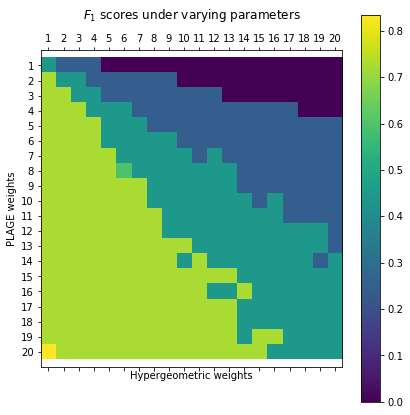

In [13]:
prob_missing_peaks = 0.2
ds = get_data_source(sample_fnames, pathway_names, percent, prob_missing_peaks, noise_mean, noise_std)
results_df, f1_mat = run_experiment(ds, pathway_names, pals_plage_weights, pals_hg_weights)
out_file = os.path.join('test_data', 'HAT', 'f1_grid_search_%f.eps' % prob_missing_peaks)
plot_heatmap(f1_mat, out_file)

Grid search with different levels of missing peaks

(1886, 8)


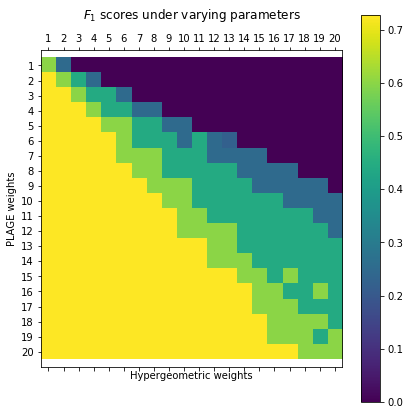

In [14]:
prob_missing_peaks = 0.4
ds = get_data_source(sample_fnames, pathway_names, percent, prob_missing_peaks, noise_mean, noise_std)
results_df, f1_mat = run_experiment(ds, pathway_names, pals_plage_weights, pals_hg_weights)
out_file = os.path.join('test_data', 'HAT', 'f1_grid_search_%f.eps' % prob_missing_peaks)
plot_heatmap(f1_mat, out_file)

(1231, 8)


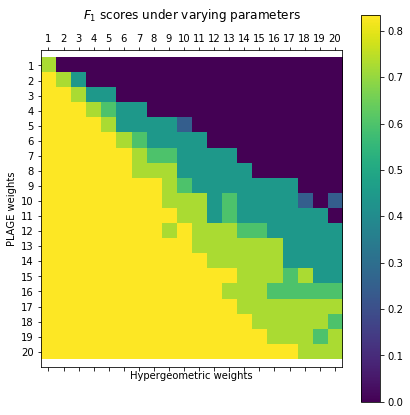

In [15]:
prob_missing_peaks = 0.6
ds = get_data_source(sample_fnames, pathway_names, percent, prob_missing_peaks, noise_mean, noise_std)
results_df, f1_mat = run_experiment(ds, pathway_names, pals_plage_weights, pals_hg_weights)
out_file = os.path.join('test_data', 'HAT', 'f1_grid_search_%f.eps' % prob_missing_peaks)
plot_heatmap(f1_mat, out_file)

(611, 8)


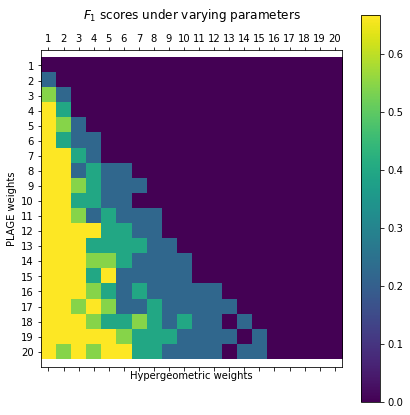

In [16]:
prob_missing_peaks = 0.8
ds = get_data_source(sample_fnames, pathway_names, percent, prob_missing_peaks, noise_mean, noise_std)
results_df, f1_mat = run_experiment(ds, pathway_names, pals_plage_weights, pals_hg_weights)
out_file = os.path.join('test_data', 'HAT', 'f1_grid_search_%f.eps' % prob_missing_peaks)
plot_heatmap(f1_mat, out_file)